In [10]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt

from bayesml import bernoulli

NUM_PARAMS = 20
NUM_SAMPLE = 20
SAMPLE_SIZE = 25
STEP = 5

H_ALPHA =0.5
H_BETA = 0.5

def zero_one_loss(y,y_hat):
    if y == y_hat:
        return 0
    else:
        return 1

def squared_loss(y,y_hat):
    return (y-y_hat)**2

In [11]:
# パラメータ，データ，結果を保存するフォルダを作成
for i in range(NUM_PARAMS):
    for j in range(NUM_SAMPLE):
        os.makedirs(f"./data/{i:02}/{j:02}")

In [12]:
# パラメータ，データを生成
model = bernoulli.GenModel(h_alpha=H_ALPHA,h_beta=H_BETA,seed=123)
model.save_h_params("./data/hparams")
for i in range(NUM_PARAMS):
    model.gen_params()
    model.save_params(f"./data/{i:02}/params")
    
    for j in range(NUM_SAMPLE):
        model.save_sample(f"./data/{i:02}/{j:02}/sample",SAMPLE_SIZE)

In [13]:
# ベイズリスク確認
loss_proposal = np.zeros([NUM_PARAMS,NUM_SAMPLE,SAMPLE_SIZE//STEP])
loss_comparison = np.zeros([NUM_PARAMS,NUM_SAMPLE,SAMPLE_SIZE//STEP])
model = bernoulli.LearnModel(h0_alpha=H_ALPHA,h0_beta=H_BETA)
for i in range(NUM_PARAMS):
    true_param = np.load(f"./data/{i:02}/params.npz")["p"]

    for j in range(NUM_SAMPLE):
        sample = np.load(f"./data/{i:02}/{j:02}/sample.npz")["X"]

        for  k in range(SAMPLE_SIZE//STEP):
            model.reset_hn_params()
            model.update_posterior(sample[:(k+1)*STEP])
            loss_proposal[i,j,k] = squared_loss(true_param, model.estimate_params(loss="squared"))
            loss_comparison[i,j,k] = squared_loss(true_param, model.estimate_params(loss="0-1"))
            
        np.save(f"./data/{i:02}/{j:02}/loss_proposal",loss_proposal[i,j])
        np.save(f"./data/{i:02}/{j:02}/loss_comparison",loss_comparison[i,j])

    np.save(f"./data/{i:02}/risk_proposal",loss_proposal[i].sum(axis=0)/NUM_SAMPLE)
    np.save(f"./data/{i:02}/risk_comparison",loss_comparison[i].sum(axis=0)/NUM_SAMPLE)

np.save("./data/bayes_risk_proposal",loss_proposal.sum(axis=(0,1))/NUM_PARAMS/NUM_SAMPLE)
np.save("./data/bayes_risk_comparison",loss_comparison.sum(axis=(0,1))/NUM_PARAMS/NUM_SAMPLE)

print(loss_proposal.sum(axis=(0,1))/NUM_PARAMS/NUM_SAMPLE)
print(loss_comparison.sum(axis=(0,1))/NUM_PARAMS/NUM_SAMPLE)

[0.01988765 0.01109221 0.00749352 0.00565451 0.00478542]
[0.02674216 0.01412451 0.00919641 0.00683949 0.00562606]


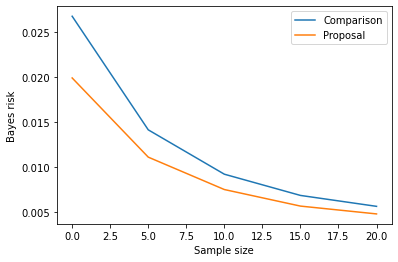

In [14]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,SAMPLE_SIZE,STEP),loss_comparison.sum(axis=(0,1))/NUM_PARAMS/NUM_SAMPLE,label="Comparison")
ax.plot(np.arange(0,SAMPLE_SIZE,STEP),loss_proposal.sum(axis=(0,1))/NUM_PARAMS/NUM_SAMPLE,label="Proposal")
ax.set_xlabel("Sample size")
ax.set_ylabel("Bayes risk")
ax.legend()